<b><h2 style="color: red">Spam link detector</h2></b>
Model trained and optimized in my Github repository <a href="https://github.com/dorianDraper/NLP-projects/blob/main/src/spam_detection_project.ipynb" target="_blank">NLP-projects</a>.

In [2]:
# Load libraries
import pandas as pd
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pickle import dump

<b><h3 style="color: green">Dataset and EDA</h3></b>

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
print(df['is_spam'].value_counts())
print('*'*50)
print(df.shape)

is_spam
False    2303
True      696
Name: count, dtype: int64
**************************************************
(2999, 2)


In [5]:
# Using a lambda function, transform the Category column to binary where spam = 1 and no spam = 0
df["is_spam"] = df["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [6]:
# Check if there are any missing values in the data
missing_values = df.isnull().sum()
missing_values

url        0
is_spam    0
dtype: int64

In [7]:
# Eliminate duplicates if any and check the shape of the data
df = df.drop_duplicates()
df = df.reset_index(inplace=False, drop=True)
df.shape

(2369, 2)

In [8]:
print(f"Spam: {df['is_spam'].value_counts()[1]}")
print(f"Not Spam: {df['is_spam'].value_counts()[0]}")

Spam: 244
Not Spam: 2125


<b><h3 style="color: green">Text Processing</h3></b>

In [9]:
def preprocess_url(url):
    # Remove any character that is not a letter (a-z) or white space ( )
    url = re.sub(r'[^a-z ]', " ", url)
    
    # Remove white spaces
    url = re.sub(r'\s+[a-zA-Z]\s+', " ", url)
    url = re.sub(r'\^[a-zA-Z]\s+', " ", url)

    # Multiple white spaces into one
    url = re.sub(r'\s+', " ", url.lower())

    # Remove tags
    url = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", url)
    
    return url.split()

df['url'] = df['url'].apply(preprocess_url)
df.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


In [10]:
download('wordnet') # WordNet is a lexical database for the English language that helps the script determine the base word
download('stopwords') # Stopwords are the English words which does not add much meaning to a sentence, they are ignored without sacrificing the meaning of the sentence (example, he, have, at...)
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

df['url'] = df['url'].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to C:\Users\Jorge
[nltk_data]     Payà\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jorge
[nltk_data]     Payà\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


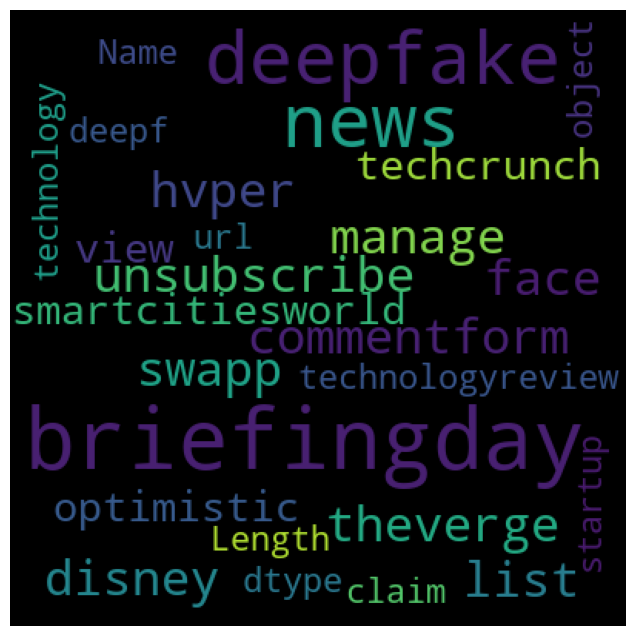

In [11]:
wordcloud = WordCloud(width = 400, height = 400, background_color = 'black', 
                      max_words = 1000, min_font_size = 20, random_state = 42).generate(str(df['url']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [12]:
tokens_list = df['url']
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, min_df = 5, max_df = 0.8)
X = vectorizer.fit_transform(tokens_list).toarray()
y = df["is_spam"]
X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
dump(vectorizer,open('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/Web-App-Streamlit/models/vectorizer_42.sav', 'wb'))

<b><h3 style="color: green">Training the Model</h3></b>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
model = SVC(kernel = 'linear', random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [15]:
y_pred = model.predict(X_test)
y_pred[:5]

array([0, 0, 1, 0, 0])

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: %.2f" % (accuracy*100), "%")

Accuracy: 95.15 %


<div class="alert alert-block alert-success">
With the default parameters, we get a 95.15% accuracy score. Next step we are going to optimize its hyperparameters using a grid search or a random search.
</div>

In [18]:
dump(model, open('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/Web-App-Streamlit/models/spam_url_detector_42.sav', 'wb'))

<b><h3 style="color: green">Model Optimization</h3></b>

In [20]:
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100], # Regularization parameter
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"], # Kernel type
    "degree": [1, 2, 3, 4, 5], # Degree of the polynomial kernel function
    "gamma": ["scale", "auto"] # Kernel coefficient
}

model_grid_search = GridSearchCV(SVC(), hyperparams, cv = 5, scoring='accuracy')
model_grid_search

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [21]:
model_grid_search.fit(X_train, y_train)

c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
300 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python311\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validat

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [22]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")

Best hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


In [25]:
model2 = SVC(C = 1, degree = 2, gamma = 'scale', kernel = 'poly', random_state = 42)
model2.fit(X_train, y_train)

SVC(C=1, degree=2, kernel='poly', random_state=42)

In [26]:
ypred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, ypred2)
print(f"Accuracy: %.2f" % (accuracy2*100), "%")

Accuracy: 96.41 %


<div class="alert alert-block alert-success">
By adjusting the parameters to {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'} we get a 96.41% accuracy score.
</div>

In [27]:
dump(model2, open('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/Web-App-Streamlit/models/spam_url_detector_svc_C-1_deg-2_gam-scale_ker-poly_42.sav', 'wb'))

In [35]:
# Let's test the model with a new URLs to see if it is spam or not
new_urls = ["https://www.google.com", "https://www.buythisnow.com", "https://www.4geeksacademy.com", "http://spambriefingday.com/fan"]
new_urls = [preprocess_url(url) for url in new_urls]
new_urls = [lemmatize_text(url) for url in new_urls]
new_urls = [" ".join(url) for url in new_urls]
new_urls = vectorizer.transform(new_urls).toarray()

model2.predict(new_urls)

array([0, 0, 0, 0])

In [ ]:
# Now we want to create a streamlit app to use the model we just created to predict if a URL is spam or not
# We will create a file called app.py to create the app
# We will use the following libraries: streamlit, pandas, pickle
# We will load the model and the vectorizer we just created
# We will create a function to preprocess the URL
# We will create a function to predict if the URL is spam or not
# We will create the app interface
# We will run the app
#
# The app.py file is in the same folder as this file
# To run the app, we need to open the terminal and run the following command:
# streamlit run app.py
# The app will open in the browser
# We can enter a URL and the app will tell us if it is spam or not
# We can test the model with the URLs we used before
# We can also test the model with other URLs to see if it is spam or not
# The app will show us the result
# provide the code for this


import streamlit as st 
import pandas as pd
from pickle import load

def preprocess_url(url):
    url = re.sub(r'[^a-z ]', " ", url)
    url = re.sub(r'\s+[a-zA-Z]\s+', " ", url)
    url = re.sub(r'\^[a-zA-Z]\s+', " ", url)
    url = re.sub(r'\s+', " ", url.lower())
    url = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", url)
    return url.split()

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

def predict_spam(url):
    url = preprocess_url(url)
    url = lemmatize_text(url)
    url = [" ".join(url)]
    url = vectorizer.transform(url).toarray()
    prediction = model2.predict(url)
    return prediction

model = load(open('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/Web-App-Streamlit/models/spam_url_detector_svc_C-1_deg-2_gam-scale_ker-poly_42.sav', 'rb'))
vectorizer = load(open('C:/Users/Jorge Payà/Desktop/4Geeks/DSML Bootcamp/Web-App-Streamlit/models/vectorizer_42.sav', 'rb'))

st.title("URL Spam Detector")
url = st.text_input("Enter a URL:")
if st.button("Predict"):
    prediction = predict_spam(url)
    if prediction == 1:
        st.write("This URL is spam")
    else:
        st.write("This URL is not spam")

# The app is ready to use
# We can enter a URL and the app will tell us if it is spam or not
# We can test the model with the URLs we used before
# We can also test the model with other URLs to see if it is spam or not
# The app will show us the result